In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from timeit import default_timer as timer
import pandas as pd

# Bellman operator

In [4]:
class Model:
    
    def __init__(self, α=0.4, β=0.96, δ=0.04, k_range=[5,20], N=1000):
        self.α, self.β, self.δ = α, β, δ
        self.k_range = k_range
        self.N = N
        self.grid = np.linspace(k_range[0], k_range[1], N)
        self.k_ss = (α/(1/β+δ-1))**(1/(1-α))
        self.c_ss = (self.k_ss)**α-δ*self.k_ss
        self.η = self.c_ss/(self.k_ss**self.α)  # 1-(δ*α/(1/β+δ-1))
        
    def budget_constraint(self, k, k_prime):
        α, β, δ = self.α, self.β, self.δ
        return k**α+(1-δ)*k-k_prime
    
    def utility_function(self, k, k_prime):
        α, β, δ = self.α, self.β, self.δ
        c=self.budget_constraint(k, k_prime)
        return np.log(c)
    
    def consumption_hat(self, k):
        η, α = self.η, self.α
        return η*k**α
    
    def LMC_eta(self, k):
        α, β, δ = self.α, self.β, self.δ
        η=mod.η
        return (1-δ)*k+(1-η)*k**α

    def create_path(self, k0, T=200):
        α, β, δ, η = self.α, self.β, self.δ, self.η
        capital_path=np.empty(T)
        capital_path[0]=k0
        value_of_utility = 0

        for t in range(T-1):
            kt = capital_path[t]
            kt1 = self.LMC_eta(kt)
            capital_path[t+1]=kt1
            util = (β**t)*np.log(η*kt**α)
            value_of_utility+=util

        return capital_path, value_of_utility
        

def bellman_operator(mod, w, Tw=None, compute_policy=False, compute_consumption=False):
    α, β, δ = mod.α, mod.β, mod.δ
    U = mod.utility_function
    BC = mod.budget_constraint
    grid=mod.grid
    
    if Tw is None:
        Tw = np.empty_like(w)
        
    if compute_policy:
        k_optims = np.empty_like(w)
    if compute_consumption:
        c_optims = np.empty_like(w)
        
    for i, k in enumerate(grid):
        def objective(k_prime):
            # interpolation - looking for optimal k_prime on the current 
            return -U(k, k_prime)-β*np.interp(x=k_prime, xp=grid, fp=w)
        
        k_prime_max = BC(k,0)
        k_star = fminbound(objective, mod.k_range[0], k_prime_max)
        c_star = BC(k, k_star)
        
        if compute_policy:
            k_optims[i]=k_star
        if compute_consumption:
            c_optims[i]=c_star
            
        Tw[i]=-objective(k_star)
  
    if compute_policy and compute_consumption:
        return Tw, k_optims, c_optims
    elif compute_policy:
        return Tw, k_optims
    elif compute_consumption:
        return Tw, c_optims
    else:
        return Tw
    
def find_and_plot_w(mod, w, max_iter=250, verbose=False):
    grid=mod.grid
    β=mod.β

    fig = plt.figure(figsize=(15,6))
    size = (2,2)
    ax=plt.subplot2grid(size, (0,0), rowspan=2)
    ax2=plt.subplot2grid(size, (0,1))
    ax3=plt.subplot2grid(size, (1,1))
    ax.set_xlim(np.min(grid), np.max(grid))

    # VALUE FUNCTION
    ax.plot(grid, w, color=plt.cm.jet(0), lw=2, label='initial guess')

    tol=0.0001
    j=0
    error=1
    start = timer()
    while j<max_iter and error>tol:
        w_new = bellman_operator(mod, w)
        error = np.max(np.abs(w_new-w))
        if j%5==0:
            ax.plot(grid, w, color=plt.cm.jet(j/50), alpha=0.5)

        error = np.max(np.abs(w_new-w))
        w[:] = w_new
        j+=1

    w_final, k_policy, c_optimal = bellman_operator(mod, w, compute_policy=True, compute_consumption=True)
    end = timer()
    
    # PLOT VALUE FUNCTION
    ax.plot(grid, w_final, color='k', lw=3, label='final value function')
    ax.set_xlabel('k', fontsize=15)
    ax.set_ylabel('$V_n(k)$', fontsize=15)
    ax.set_title('Value function', fontsize=20)
    ax.legend(loc=2, fontsize=12)

    # PLOT POLICY FUNCTIONS
    ax2.plot(grid, k_policy, 'k-', label='approximate policy function')
    ax2.axhline(mod.k_ss, alpha=0.5, ls='dashed', c='k', label='s.s. of capital')
    ax2.set_xlabel('$k$', fontsize=15)
    ax2.set_ylabel("$k'$", fontsize=15)
    ax2.set_title('Policy function', fontsize=20)
    ax2.legend(loc=4, fontsize=12)

    ax3.plot(grid, c_optimal, 'k-', label='consumption')
    ax3.axhline(mod.c_ss, alpha=0.5, ls='dashed',c='k', label='s.s. of consumption')
    ax3.set_xlabel("$k, \quad k'$", fontsize=15)
    ax3.set_ylabel('$c$', fontsize=15)
    ax3.set_title('Optimal consumption', fontsize=20)
    ax3.legend(loc=4, fontsize=12)

    plt.tight_layout()
    plt.show()
    
    if verbose:
        print('='*10, 'INFORMATION', '='*10)
        print('steady state of capital: {0}'.format(mod.k_ss))
        print('steady state of consumption: {0}'.format(mod.c_ss))
        print('\nloop stopped at iteration: ', j)
        print('\nelapsed time: {}'.format(end-start))
    
    return w_final, k_policy, c_optimal

## Problem 1a)

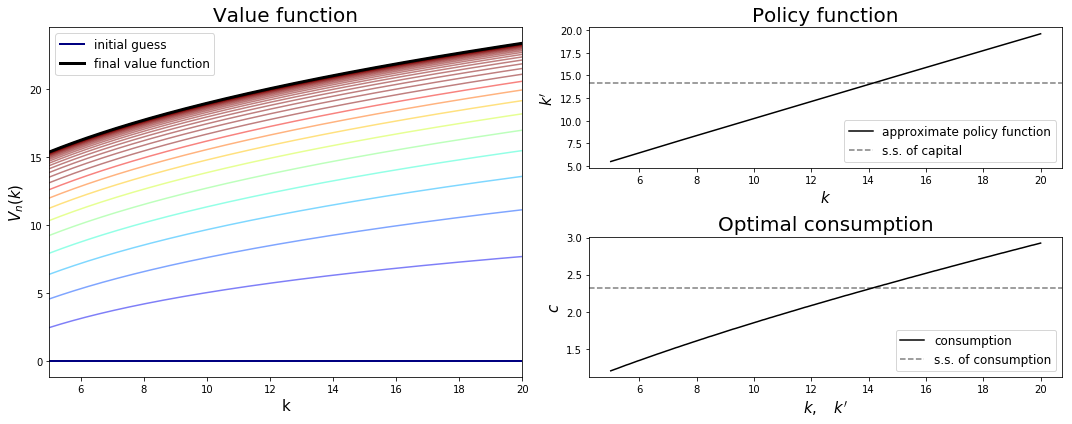

========== INFORMATION ==========
steady state of capital: 14.126197356650485
steady state of consumption: 2.3190507327167915

loop stopped at iteration:  218

elapsed time: 145.09240340985076


In [5]:
mod = Model()
w_final_a, k_policy_a, c_optimal_a = find_and_plot_w(mod, w=np.zeros(mod.N), verbose=True)

## Problem 1b)

### Steady states of variables

#### $ k^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $

#### $ c^* = \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{\alpha}{1-\alpha}} - \delta \Big(\frac{\alpha}{1/\beta+\delta-1}\Big)^{\frac{1}{1-\alpha}} $ 

### Discounted lifetime utility

#### $\hat{v}_0(k) = \sum_{t=0}^{\infty} \log \eta k_t^\alpha$

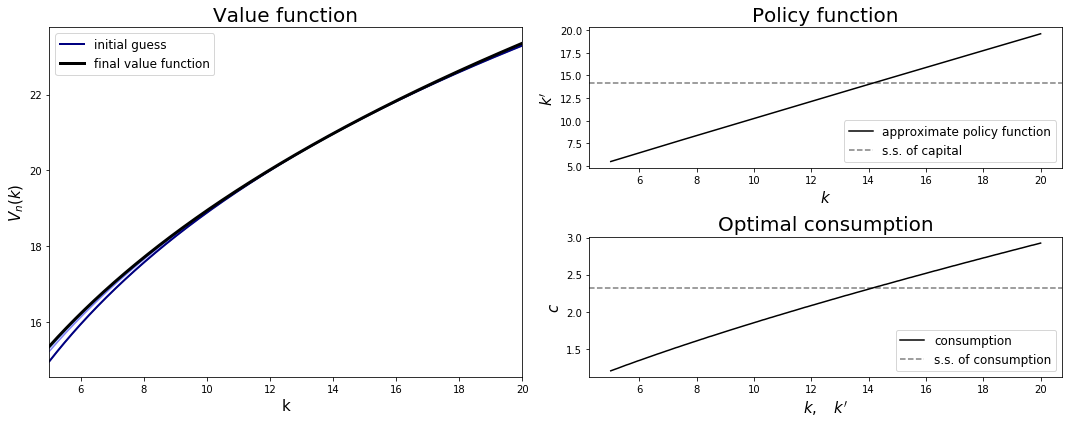

========== INFORMATION ==========
steady state of capital: 14.126197356650485
steady state of consumption: 2.3190507327167915

loop stopped at iteration:  39

elapsed time: 27.137945008226097


In [6]:
mod = Model()
grid=mod.grid
β=mod.β

w0 = np.empty(len(grid))
for i, k0 in enumerate(grid):
    _, value_of_utility = mod.create_path(k0)
    w0[i] = value_of_utility

w_final_b, k_policy_b, c_optimal_b = find_and_plot_w(mod, w=w0, verbose=True)

## Problem 1c)

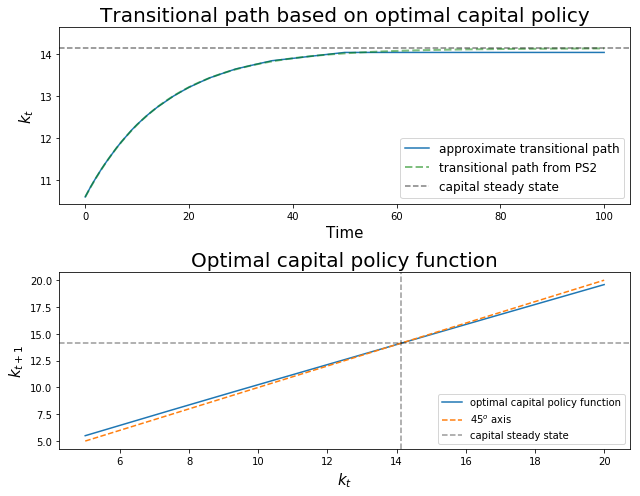

In [7]:
mod=Model()
grid = mod.grid
fig, (ax, ax2) = plt.subplots(2,1,figsize=(9,7))

def find_nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

kt = mod.k_ss*0.75
capital_path=[kt]

for i in range(1,101):
    kt_grid_i = find_nearest_index(grid, kt)
    ktp1 = k_policy_a[kt_grid_i]
    kt = ktp1
    capital_path.append(kt)
    
capital_path_PS2 = pd.read_pickle('PS2_capital_path.pickle')

ax.plot(range(len(capital_path)), capital_path, label='approximate transitional path')
ax.plot(range(len(capital_path_PS2)), capital_path_PS2, ls='dashed', alpha=0.5, lw=2, c='g', label='transitional path from PS2')
ax.axhline(mod.k_ss, c='k', ls='dashed', alpha=0.5, label='capital steady state')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('$k_t$', fontsize=15)
ax.set_title('Transitional path based on optimal capital policy', fontsize=20)
ax.set_ylim(ymax=mod.k_ss+0.5)
ax.legend(loc=4, fontsize=12)

ax2.plot(grid, k_policy_a, label='optimal capital policy function')
ax2.plot(grid, grid, ls='dashed', label='$45^o$ axis')
ax2.axhline(mod.k_ss, c='k', alpha=0.4, ls='dashed', label='capital steady state')
ax2.axvline(mod.k_ss, c='k', alpha=0.4, ls='dashed')
ax2.set_xlabel('$k_t$', fontsize=15)
ax2.set_ylabel('$k_{t+1}$', fontsize=15)
ax2.set_title('Optimal capital policy function', fontsize=20)
ax2.legend(loc=4, fontsize=10)

plt.tight_layout()
plt.show()